In [53]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    confusion_matrix,
    adjusted_rand_score,
    adjusted_mutual_info_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import umap
import hdbscan
from tqdm import tqdm
import requests
import os
import tarfile
import pandas as pd

In [93]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # initialize the model based on best available device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")


    feature_extractor = FeatureExtractor().to(device).eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.to(device)).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

# Question 19

Even if the VGG network was pre-trained using a dataset with different classes, the features it learns are enough to retain discriminative ability when applied to a custom dataset. Early and mid-layers in VGG capture basic visual patterns such as edges, textures and shapes, which can be applied broadly across different image domains and can be helpful as a foundation for distinguishing new classes. That means the network can tell new types of images apart based on these pre-learned representations.


# Question 20
The provided helper code first loads the flower images are already on the system, and if they aren't, it downloads the flowers dataset. It then loads the images in batches and applies preprocessing steps such as normalization, center cropping, and resizing. It uses a pre-trained VGG-16 model to extract features by passing images through its feature layers, which capture hierarchical patterns such as edges, shapes, and textures. It then applies average pooling to reduce feature dimensionality and flattens the pooled feature maps into a one-dimensional vector. Finally, the helper code passes the flattened features through the first fully connected layer of the VGG-16 classifier, transforming them into a compact 4096-dimensional feature vector. These extracted features provide a more discriminative representation of each image.

# Question 21
224 × 224 × 3 = 150528 pixels

In [46]:
num_features = f_all.shape[1]
print(f"The dimension of each feature vector for an image sample: {num_features}")

The dimension of each feature vector for an image sample: 4096


# Question 22

In [47]:
# Compute the percentage of zero elements in the feature matrix
zero_mask = (f_all == 0)  
num_zeros = np.sum(zero_mask)  
total_elements = f_all.size  
percentage_zeros = (num_zeros / total_elements) * 100 

print(f"Percentage of zero elements in the array: {percentage_zeros:.2f}%")

Percentage of zero elements in the array: 0.00%


The extracted features are dense because most of their elements are nonzero since they capture detailed visual patterns. In contrast, TF-IDF features are sparse, as most of their elements are zero due to documents only containing a fraction of all possible words.

# Question 23

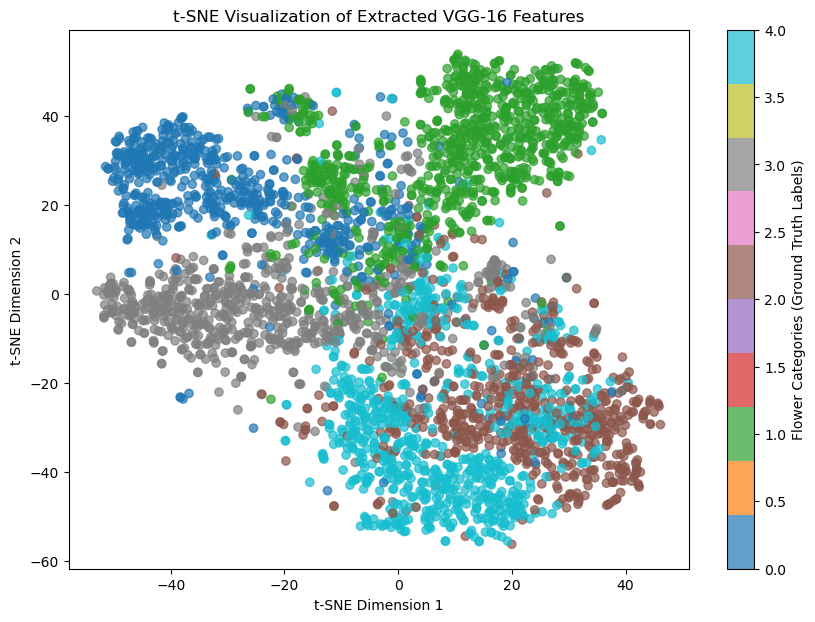

In [42]:
# applying t-SNE to reduce 4096-dimensional features to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
f_all_2d = tsne.fit_transform(f_all)

# plot the 2D mapped features
plt.figure(figsize=(10, 7))
scatter = plt.scatter(f_all_2d[:, 0], f_all_2d[:, 1], c=y_all, cmap='tab10', alpha=0.7)

# legend for interpretation
plt.colorbar(scatter, label="Flower Categories (Ground Truth Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Extracted VGG-16 Features")
plt.show()

Here, the t-SNE visualization maps the high dimensional feature vector onto a 2D space, which shows clusters where each point represents an image, and the colors indicate different flower categories based on ground-truth labels. Some of the clusters are very clearly separated, which shows that VGG-16 does successfully capture visual features that differentiate certain flower types. There is some overlap though between the categories, which means that some flowers could have similar textures, colors, or shapes. This can make it harder to distinguish between them. Also, the clusters differ in size and density, as some of them are tightly packed, while some of them are more spread out. Tightly packed clusters represents more consistent features, while the spread out ones mean that they have greater intra-class variability.

# Question 24

In [54]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.to(device)
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.to(device)
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [56]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2)

# train autoencoder
autoencoder = Autoencoder(n_components=50).fit(X_train)
X_autoencoded = autoencoder.transform(X_train)

# define possible dimensionality reduction approaches
def apply_dimensionality_reduction(method, X):
    if method == 'None':
        return X
    elif method == 'SVD':
        return TruncatedSVD(n_components=50).fit_transform(X)
    elif method == 'UMAP':
        return umap.UMAP(n_components=50, random_state=42).fit_transform(X)
    elif method == 'Autoencoder':
        return autoencoder.transform(X)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")

# helper for the standard clustering methods
def apply_clustering(method, X, k=5, min_cluster_size=10, min_samples=2):
    if method == 'K-Means':
        return KMeans(n_clusters=k, random_state=42).fit_predict(X)
    elif method == 'Agglomerative':
        return AgglomerativeClustering(n_clusters=k).fit_predict(X)
    elif method == 'HDBSCAN':
        return hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit_predict(X)
    else:
        raise ValueError(f"Unknown clustering method: {method}")

# store results
results = []
dim_reduction_methods = ["None", "SVD", "UMAP", "Autoencoder"]
clustering_methods = ["K-Means", "Agglomerative"]
hdbscan_configs = {'min_cluster_size': [5, 10, 15], 'min_samples': [5, 10, 15]}

for dr_method in tqdm(dim_reduction_methods, desc="Dimensionality Reduction Methods"):
    X_reduced = apply_dimensionality_reduction(dr_method, X_train)

    for cluster_method in clustering_methods:
        y_pred = apply_clustering(cluster_method, X_reduced)
        score = adjusted_rand_score(y_train, y_pred)
        results.append([dr_method, cluster_method, cluster_method, "k=5" if cluster_method == "K-Means" else "n_clusters=5", score])

    # HDBSCAN 
    for min_size in hdbscan_configs['min_cluster_size']:
        for min_samp in hdbscan_configs['min_samples']:
            y_pred = apply_clustering("HDBSCAN", X_reduced, min_cluster_size=min_size, min_samples=min_samp)
            valid_indices = y_pred != -1
            score = adjusted_rand_score(y_train[valid_indices], y_pred[valid_indices]) if np.any(valid_indices) else -1
            results.append([dr_method, "HDBSCAN", "HDBSCAN", f"min_cluster_size={min_size}, min_samples={min_samp}", score])

# convert to dataframe
df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering", "Alternatives", "Hyperparameters", "ARI Score"])
df_results = df_results.sort_values(by="ARI Score", ascending=False)

# display results
df_results.to_csv("clustering_results.csv.gz", index=False)
display(df_results)  

Dimensionality Reduction Methods:  50%|█████     | 2/4 [07:45<06:24, 192.33s/it]/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Dimensionality Reduction Methods: 100%|██████████| 4/4 [08:02<00:00, 120.61s/it]


,Dimensionality Reduction,Clustering,Alternatives,Hyperparameters,ARI Score
26,UMAP,HDBSCAN,HDBSCAN,"min_cluster_size=5, min_samples=15",0.540438
32,UMAP,HDBSCAN,HDBSCAN,"min_cluster_size=15, min_samples=15",0.540204
29,UMAP,HDBSCAN,HDBSCAN,"min_cluster_size=10, min_samples=15",0.534312
22,UMAP,K-Means,K-Means,k=5,0.382423
23,UMAP,Agglomerative,Agglomerative,n_clusters=5,0.380267
1,None,Agglomerative,Agglomerative,n_clusters=5,0.277268
11,SVD,K-Means,K-Means,k=5,0.235118
33,Autoencoder,K-Means,K-Means,k=5,0.209088
0,None,K-Means,K-Means,k=5,0.207309
34,Autoencoder,Agglomerative,Agglomerative,n_clusters=5,0.159290


# Question 25

In [91]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.to(device)
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        y = torch.tensor(y, dtype=torch.int64, device=device)

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        total_loss = 0 
        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()  # reset gradients
                output = self.model(X_)  
                loss = criterion(output, y_)  # calculate loss
                loss.backward()  
                optimizer.step()  # update parameters

                total_loss += loss.item()  
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
        y_test = torch.tensor(y_test, dtype=torch.int64, device=device)

        self.model.eval()  
        
        # disable gradient computation during evaluation
        with torch.no_grad():
            outputs = self.model(X_test)  
            _, predicted = torch.max(outputs, 1)
            
            # calculate accuracy
            correct = (predicted == y_test).sum().item()  
            accuracy = correct / len(y_test)  
        
        return accuracy * 100 

In [105]:
# train + evaluate MLP on original VGG features
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

mlp_vgg = MLP(num_features=4096)
mlp_vgg.train(X_train, y_train)
accuracy_vgg = mlp_vgg.eval(X_test, y_test)
print(f"Test Accuracy on VGG Features: {accuracy_vgg:.2f}%")

100%|██████████| 100/100 [00:24<00:00,  4.07it/s]

Test Accuracy on VGG Features: 90.19%


In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    f_all, y_all, test_size=0.2, random_state=42
)

# apply TruncatedSVD to reduce the dimensionality to 50
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

# train an MLP on the 50-D reduced features
mlp_svd = MLP(num_features=50)  # Notice 50 instead of 4096
mlp_svd.train(X_train_reduced, y_train)

# evaluation
accuracy_svd = mlp_svd.eval(X_test_reduced, y_test)
print(f"Test Accuracy with SVD-reduced features: {accuracy_svd:.2f}%")


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]

Test Accuracy with SVD-reduced features: 88.56%


The accuracy rate for Original VGG features is 90.19%, and for SVD-reduced features it is 88.56%. It decreased 1.63%, which shows that while dimensionality reduction techniques like SVD can keep most of the essential information in the data, some of the more highly detailed features that are useful for classification might be lost during the process. Since the remaining information achieved a 88.56% accurate rate, it suggests that the most essential features for discrimination are still kept. 

The success in classification does not align with the clustering events from Question 24. Since the SVD reduced features gave poor clustering performance, seen in ARI scores around 0.235 for K-Means and 0.132 for Agglomerative Clustering, it means that the data’s structural relationships might not have been well maintained for unsupervised learning. Even though classifications are still effective because of the presence of labeled data which is guiding the model, clustering purely relies on feature similarity, which seems to be significantly impacted by SVD. Thus, all of the clustering suggests that SVD removes structure that is necessary for unsupervised learning but still keeps enough for supervised classification.